In [1]:
import pandas as pd
import numpy as np
import os, re
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [2]:
files = list(filter(
    lambda x: '.feather' in x,
    os.listdir()))

In [3]:
data = {f: pd.read_feather(f).set_index('Unnamed: 0') for f in tqdm(files) if '.feather' in f}

100%|██████████| 74/74 [00:44<00:00,  1.65it/s]


In [4]:
for f, df in tqdm(data.items()):
    df['singular_grammaticality'] = df.candidate2_base_prob / df.candidate1_base_prob
    df['plural_grammaticality']   = df.candidate1_alt1_prob / df.candidate2_alt1_prob
    df['inv_singular_grammaticality'] = 1 / df.singular_grammaticality
    df['inv_plural_grammaticality']   = 1 / df.plural_grammaticality
    df['yz'] = df.candidate2_prob / df.candidate1_prob
    df['effect'] = df.yz / df.singular_grammaticality - 1
    df['total_effect'] = 1 / (df.plural_grammaticality * df.singular_grammaticality) - 1

100%|██████████| 74/74 [00:58<00:00,  1.27it/s]


In [5]:
data_agg  = {}
data_top5 = {}
cols = [
    'neuron', 'layer', 
    'effect', 
    'singular_grammaticality', 'plural_grammaticality', 
    'inv_singular_grammaticality', 'inv_plural_grammaticality',
    'total_effect',
]
for f, df in tqdm(data.items()):
    agg = (
        df[cols].groupby(['layer', 'neuron'])
        .agg(['mean', 'std', 'sem']))
    agg.columns = ['_'.join(col) for col in agg.columns]
    data_agg[f] = agg
    data_top5[f] = (
        agg.sort_values('effect_mean')      # Sort
        .groupby('layer')                   # Get layers
        .tail(int(agg.index.max()[1]*0.05)) # Take top 5%
        .index)                             # Get indices of top 5% by layer

100%|██████████| 74/74 [08:08<00:00,  6.60s/it]


In [6]:
data_agg[f]

effect_mean  effect_std  effect_sem  \
layer neuron                                        
0     0         -0.000173    0.001704    0.000121   
      1          0.000122    0.002817    0.000199   
      2          0.000187    0.001270    0.000090   
      3          0.000686    0.001806    0.000128   
      4         -0.000082    0.003413    0.000241   
...                   ...         ...         ...   
48    1595      -0.000101    0.001203    0.000085   
      1596      -0.000180    0.002188    0.000155   
      1597       0.003047    0.005648    0.000399   
      1598      -0.001251    0.002823    0.000200   
      1599      -0.000179    0.001395    0.000099   

              singular_grammaticality_mean  singular_grammaticality_std  \
layer neuron                                                              
0     0                           0.136953                     0.300352   
      1                           0.136953                     0.300352   
      2                           0.136953                     0.300352   
      3                           0.136953                     0.300352   
      4                           0.136953                     0.300352   
...                                    ...                          ...   
48    1595                        0.136953                     0.300352   
      1596                        0.136953                     0.300352   
      1597                        0.136953                     0.300352   
      1598                        0.136953                     0.300352   
      1599                        0.136953                     0.300352   

              singular_grammaticality_sem  plural_grammaticality_mean  \
layer neuron                                                            
0     0                          0.021238                    0.010118   
      1                          0.021238                    0.010118   
      2                          0.021238                    0.010118   
      3                          0.021238                    0.010118   
      4                          0.021238                    0.010118   
...                                   ...                         ...   
48    1595                       0.021238                    0.010118   
      1596                       0.021238                    0.010118   
      1597                       0.021238                    0.010118   
      1598                       0.021238                    0.010118   
      1599                       0.021238                    0.010118   

              plural_grammaticality_std  plural_grammaticality_sem  \
layer neuron                                                         
0     0                        0.012618                   0.000892   
      1                        0.012618                   0.000892   
      2                        0.012618                   0.000892   
      3                        0.012618                   0.000892   
      4                        0.012618                   0.000892   
...                                 ...                        ...   
48    1595                     0.012618                   0.000892   
      1596                     0.012618                   0.000892   
      1597                     0.012618                   0.000892   
      1598                     0.012618                   0.000892   
      1599                     0.012618                   0.000892   

              inv_singular_grammaticality_mean  \
layer neuron                                     
0     0                              27.819726   
      1                              27.819726   
      2                              27.819726   
      3                              27.819726   
      4                              27.819726   
...                                        ...   
48    1595                           27.819726   
      1596                           

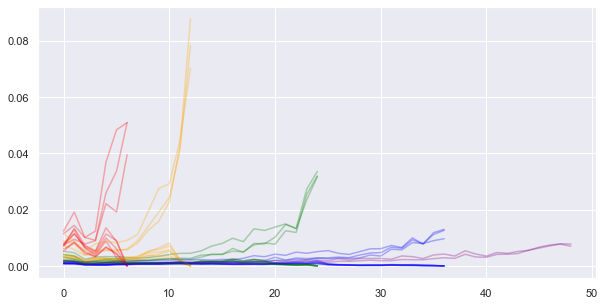

In [7]:
plt.figure(figsize=(10,5))
for f in filter(lambda x: 'indirect' in x, data_agg):
    if 'distil' in f:
        color = 'red'
    elif 'medium' in f:
        color = 'green'
    elif 'large' in f:
        color = 'blue'
    elif 'xl' in f:
        color = 'purple'
    else:
        color = 'orange'
    df = data_agg[f]
    idx = data_top5[f]
    effects = (
        df.loc[idx]
        .sort_values('layer')
        .reset_index()
        .groupby('layer')
        .mean().effect_mean
    )
    plt.plot(
        effects,
        label=f[:-8].replace('_',' '), alpha=0.3, color=color,
    )
# plt.legend()
plt.show()

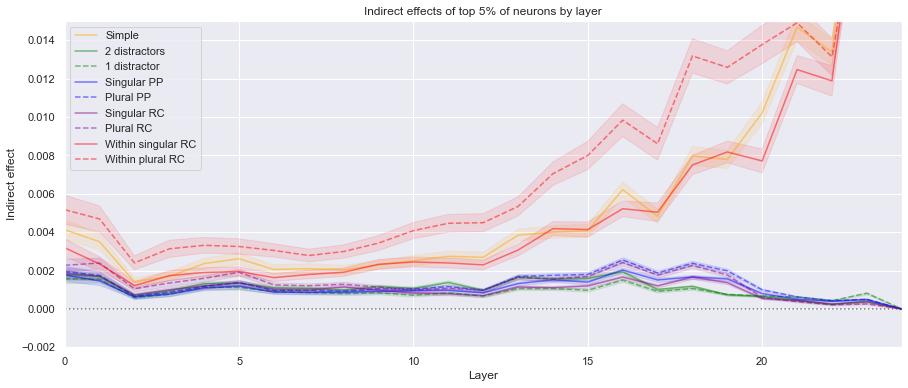

In [8]:
lines = [
    ('none_indirect_gpt2-medium.feather',         'orange',    'Simple', '-'),
    ('distractor_indirect_gpt2-medium.feather',   'green', '2 distractors', '-'),
    ('distractor_1_indirect_gpt2-medium.feather', 'green', '1 distractor',  '--'),
    ('singular_indirect_gpt2-medium.feather',     'blue',  'Singular PP',   '-'),
    ('plural_indirect_gpt2-medium.feather',       'blue',  'Plural PP',     '--'),
    ('_'.join(['rc_singular', 'indirect', 'gpt2-medium.feather']), 'purple', 'Singular RC', '-'),
    ('_'.join(['rc_plural',   'indirect', 'gpt2-medium.feather']), 'purple', 'Plural RC',   '--'),
    ('_'.join(['within_rc_singular', 'indirect', 'gpt2-medium.feather']), 'red', 'Within singular RC', '-'),
    ('_'.join(['within_rc_plural',   'indirect', 'gpt2-medium.feather']), 'red', 'Within plural RC',   '--'),
]
    
plt.figure(figsize=(15,6))
for f, color, label, linestyle in lines:
    df = data_agg[f].loc[data_top5[f]].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    plt.plot(
        df.layer.unique(), 
        effect_mean,
        label=label, color=color, linestyle=linestyle, alpha=0.5,
    )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        alpha=0.1, color=color
    )
plt.legend()
plt.title('Indirect effects of top 5% of neurons by layer')
plt.xlabel('Layer')
plt.ylabel('Indirect effect')
plt.ylim([-0.002, 0.015])
plt.hlines(0, 0, 24, color='black', alpha=0.5, linestyle='dotted')
plt.xlim([0,24])
plt.savefig('../top5.png')
plt.show()

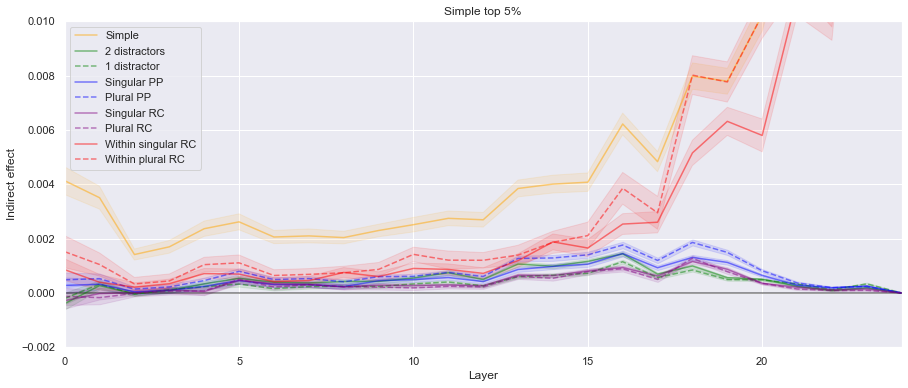

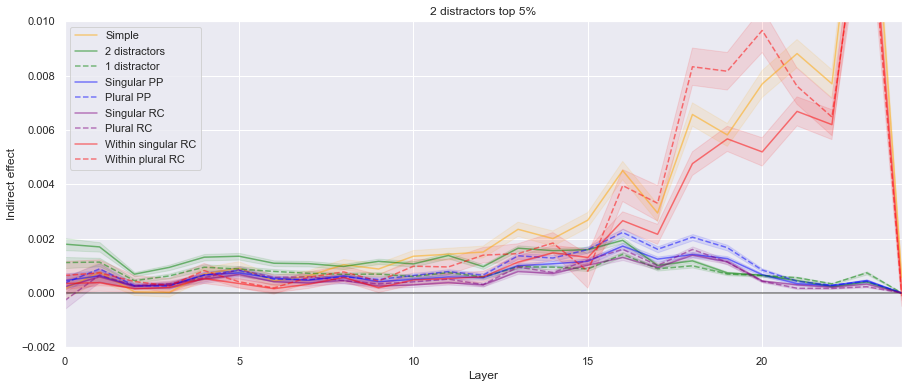

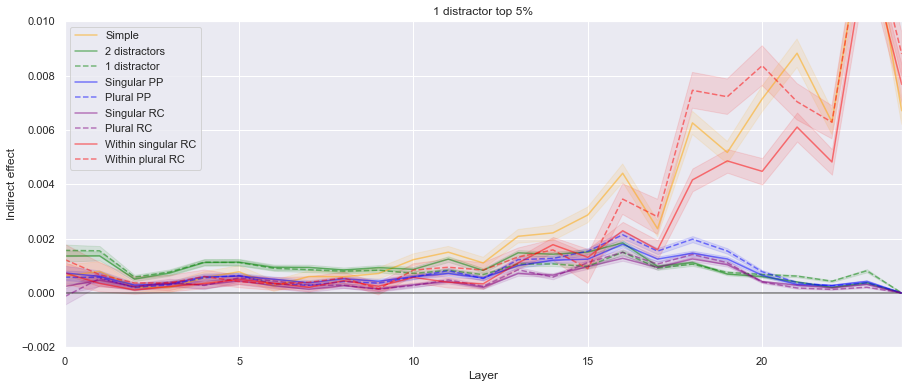

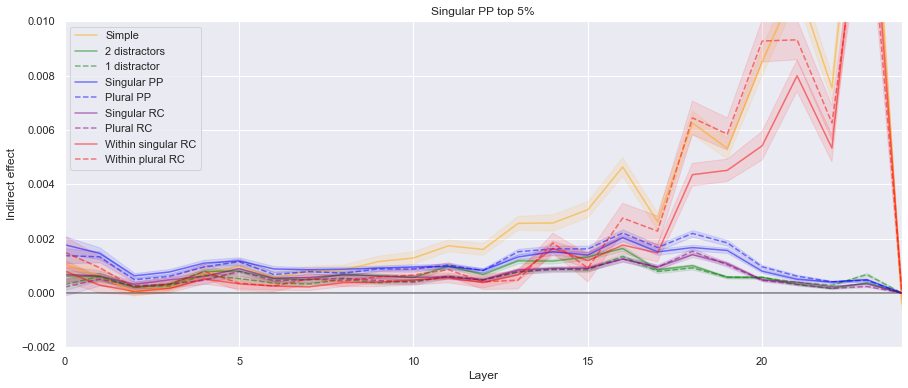

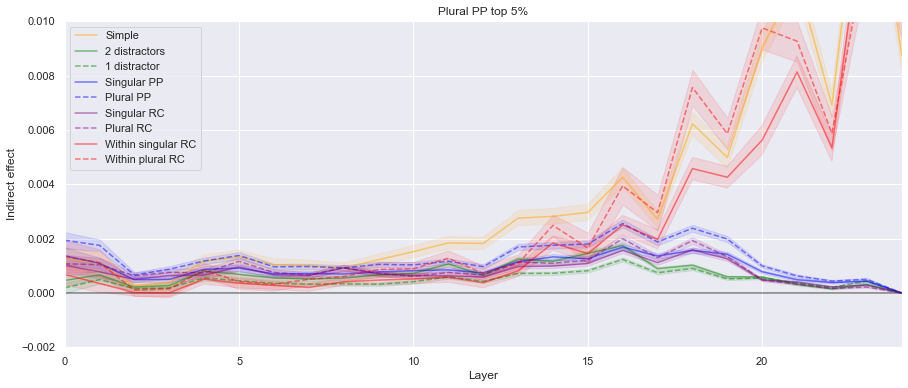

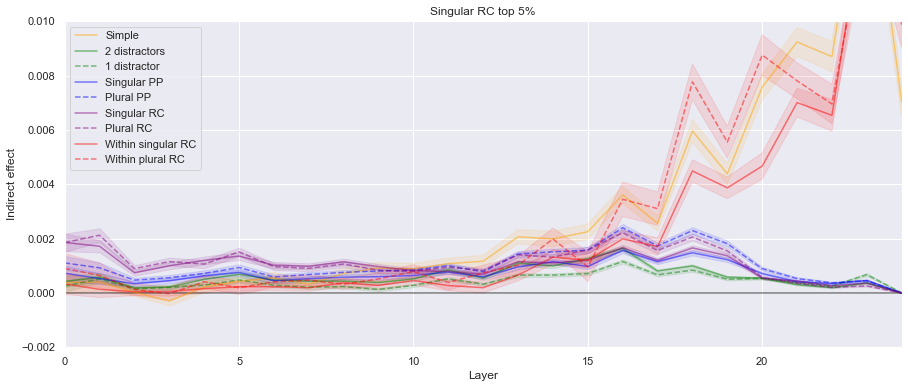

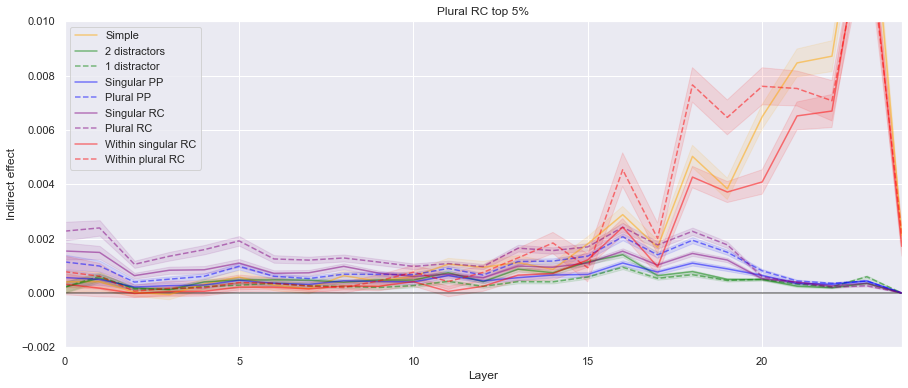

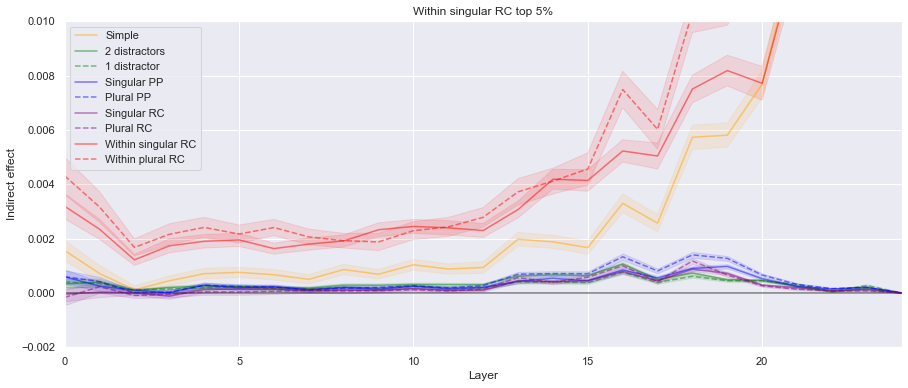

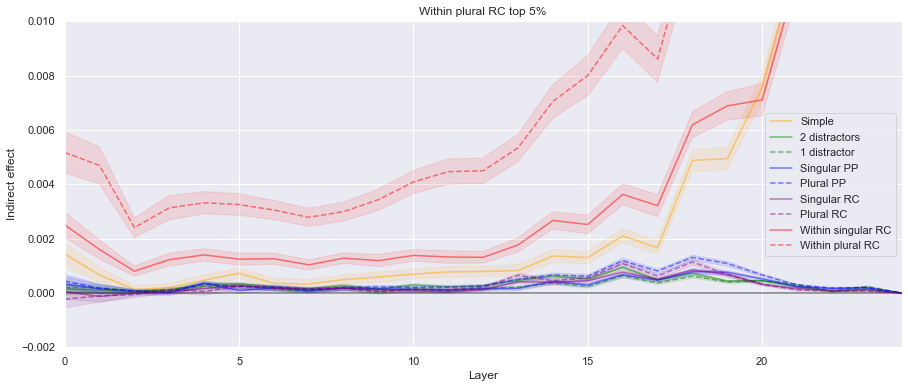

In [9]:
for g, _, title, _ in lines:
    plt.figure(figsize=(15,6))
    for f, color, label, linestyle in lines:
        df = data_agg[f].loc[data_top5[g]].sort_values('layer').reset_index()
        effect_mean = df.groupby('layer').mean().effect_mean
        effect_std = df.groupby('layer').mean().effect_sem
        plt.plot(
            df.layer.unique(), 
            effect_mean,
            label=label, color=color, linestyle=linestyle, alpha=0.5,
        )
        plt.fill_between(
            df.layer.unique(),
            effect_mean + effect_std,
            effect_mean - effect_std,
            alpha=0.1, color=color
        )
    plt.title(title + ' top 5%')
    plt.legend()
    plt.hlines(0, 0, 24, color='black', alpha=0.5)
    plt.xlim([0,24])
    plt.xlabel('Layer')
    plt.ylabel('Indirect effect')
    plt.ylim([-0.002, 0.01])
    plt.savefig('../top5.png')
    plt.show()

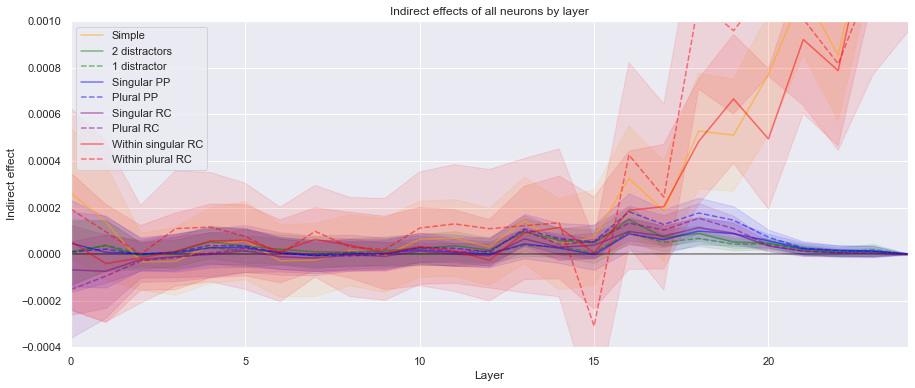

In [ ]:
plt.figure(figsize=(15,6))
for f, color, label, linestyle in lines:
    df = data_agg[f].sort_values('layer').reset_index()
    effect_mean = df.groupby('layer').mean().effect_mean
    effect_std = df.groupby('layer').mean().effect_sem
    plt.plot(
        df.layer.unique(), 
        effect_mean,
        label=label, color=color, linestyle=linestyle, alpha=0.5,
    )
    plt.fill_between(
        df.layer.unique(),
        effect_mean + effect_std,
        effect_mean - effect_std,
        alpha=0.1, color=color
    )
plt.legend()
plt.title('Indirect effects of all neurons by layer')
plt.xlabel('Layer')
plt.ylabel('Indirect effect')
plt.ylim([-0.0004, 0.001])
plt.hlines(0, 0, 24, color='black', alpha=0.5)
plt.xlim([0,24])
plt.savefig('../top5.png')
plt.show()

In [ ]:
data_agg[f].iloc[200]

effect_mean                            0.002704
effect_std                             0.005717
effect_sem                             0.000404
singular_grammaticality_mean           0.274619
singular_grammaticality_std            0.335955
singular_grammaticality_sem            0.023756
plural_grammaticality_mean             0.007932
plural_grammaticality_std              0.009146
plural_grammaticality_sem              0.000647
inv_singular_grammaticality_mean      13.498625
inv_singular_grammaticality_std       19.987312
inv_singular_grammaticality_sem        1.413316
inv_plural_grammaticality_mean       327.674767
inv_plural_grammaticality_std        395.512022
inv_plural_grammaticality_sem         27.966923
total_effect_mean                   3049.525111
total_effect_std                    6072.701853
total_effect_sem                     429.404866
Name: (0, 200), dtype: float64

100%|██████████| 9/9 [00:00<00:00, 2294.76it/s]


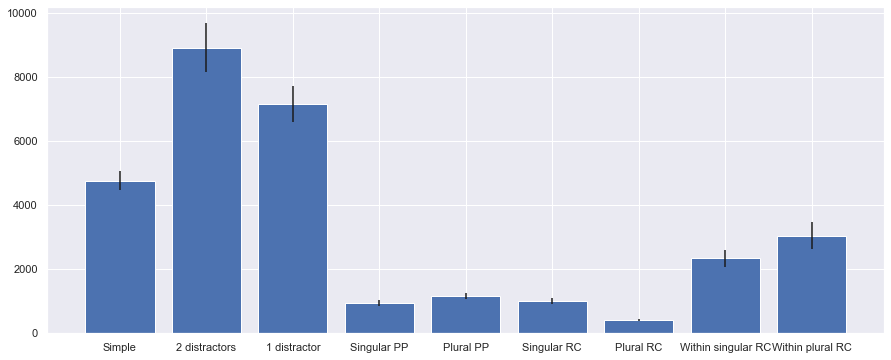

In [ ]:
plt.figure(figsize=(15,6))
labels = []
bars   = []
errors = []
for f, color, label, linestyle in tqdm(lines):
    labels.append(label)
    bars.append  (data_agg[f].iloc[0].total_effect_mean)
    errors.append(data_agg[f].iloc[0].total_effect_sem)
plt.bar(labels, bars, yerr=errors)
plt.show()

In [ ]:
# fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(15,6))
lines = [
    ('none_indirect_gpt2-medium.feather',         'orange',    'Simple', '-'),
    ('distractor_indirect_gpt2-medium.feather',   'red', '2 distractors', '-'),
    ('distractor_1_indirect_gpt2-medium.feather', 'red', '1 distractor',  '--'),
    ('singular_indirect_gpt2-medium.feather',     'green',  'Singular PP',   '-'),
    ('plural_indirect_gpt2-medium.feather',       'green',  'Plural PP',     '--'),
    ('_'.join(['rc_singular', 'indirect', 'gpt2-medium.feather']), 'blue', 'Singular RC', '-'),
    ('_'.join(['rc_plural',   'indirect', 'gpt2-medium.feather']), 'blue', 'Plural RC',   '--'),
    ('_'.join(['within_rc_singular', 'indirect', 'gpt2-medium.feather']), 'purple', 'Within singular RC', '-'),
    ('_'.join(['within_rc_plural',   'indirect', 'gpt2-medium.feather']), 'purple', 'Within plural RC',   '--'),
]

labels = []
dfs = []
for f, color, label, linestyle in tqdm(lines):
    df = data_agg[f]
    df['label'] = label
    dfs.append(df)

100%|██████████| 9/9 [00:00<00:00, 793.79it/s]


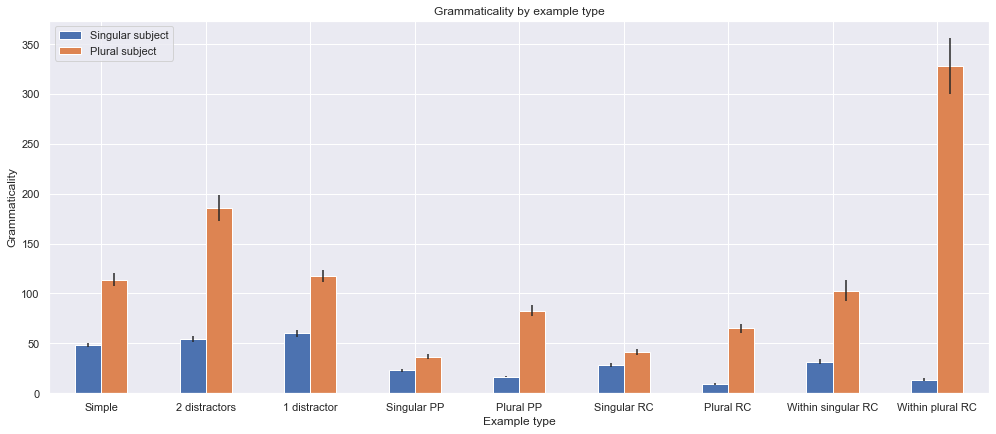

In [15]:
fig, ax = plt.subplots()
df = (
    pd.concat(dfs)
    .sort_index()
    .loc[0,0]
    .set_index('label')
    [[
        'inv_singular_grammaticality_mean','inv_plural_grammaticality_mean',
        'inv_singular_grammaticality_sem','inv_plural_grammaticality_sem'
    ]]
)
df[['inv_singular_grammaticality_mean','inv_plural_grammaticality_mean',]].plot.bar(
    figsize=(14, 6),
    rot=0,
    xlabel='Example type',
    ylabel='Grammaticality',
    yerr=df[['inv_singular_grammaticality_sem', 'inv_plural_grammaticality_sem']].values.T,
    ax=ax
)
ax.legend(['Singular subject', 'Plural subject'], loc='upper left')
plt.tight_layout()
plt.title('Grammaticality by example type')
plt.show()

- [x] Within rc
- [ ] Show size dim for TE and NIE and Grammaticality
    - [x] NIE
- [ ] Universally top neurons
- [ ] Heatmaps w/ normalized colors?

In [42]:
lines = [
    ('none_indirect_gpt2-medium.feather',         'orange',    'Simple', '-'),
    ('distractor_1_indirect_gpt2-medium.feather', 'red', '1 distractor',  '--'),
]

df1 = data[lines[0][0]]
df2 = data[lines[1][0]]

df1['name'] = lines[0][0]
df2['name'] = lines[1][0]

to_plot = (
    pd.concat([df1, df2])
    .melt(
        id_vars=('candidate1','base_string','name'), 
        value_vars=(
            'candidate1_base_prob', 'candidate2_base_prob', 'candidate1_alt1_prob', 'candidate2_alt1_prob'
        ),
        var_name='prob_type',
        value_name='prob'
    )
)

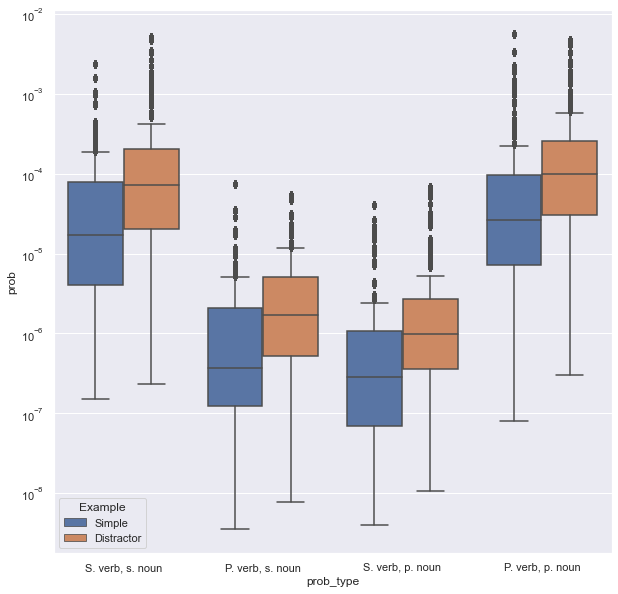

In [44]:
fig, ax = plt.subplots(figsize=(10,10))
g = sns.boxplot(x='prob_type', y='prob', data=to_plot, hue='name', ax=ax)
g.set(yscale='log')
ax.set_xticklabels((
    'S. verb, s. noun',
    'P. verb, s. noun',
    'S. verb, p. noun',
    'P. verb, p. noun'
))
# title
new_title = 'Example'
g.get_legend().set_title(new_title)
# replace labels
new_labels = ['Simple', 'Distractor']
for t, l in zip(g.get_legend().texts, new_labels): t.set_text(l)
ax.set_xlabel = None
ax.set_ylabel = 'Probability'

In [45]:
data['none_indirect_gpt2-medium.feather']

,word,base_string,alt_string1,candidate1,candidate2,candidate1_base_prob,candidate2_base_prob,candidate1_alt1_prob,candidate2_alt1_prob,candidate1_prob,...,layer,neuron,singular_grammaticality,plural_grammaticality,inv_singular_grammaticality,inv_plural_grammaticality,yz,effect,total_effect,name
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,
0,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,0,0.040475,0.007969,24.706765,125.493325,0.040467,-0.000198,3099.534150,none_indirect_gpt2-medium.feather
1,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,1,0.040475,0.007969,24.706765,125.493325,0.040701,0.005585,3099.534150,none_indirect_gpt2-medium.feather
2,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,2,0.040475,0.007969,24.706765,125.493325,0.040896,0.010399,3099.534150,none_indirect_gpt2-medium.feather
3,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,3,0.040475,0.007969,24.706765,125.493325,0.040577,0.002521,3099.534150,none_indirect_gpt2-medium.feather
4,The {}_athlete_approves,The athlete,The athletes,['Ġapproves'],['Ġapprove'],0.000005,2.050610e-07,2.611536e-08,0.000003,0.000005,...,0,4,0.040475,0.007969,24.706765,125.493325,0.040294,-0.004461,3099.534150,none_indirect_gpt2-medium.feather
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4787195,The {}_woman_observes,The woman,The women,['Ġobserves'],['Ġobserve'],0.000021,2.601502e-07,3.010518e-07,0.000014,0.000021,...,24,1019,0.012406,0.020804,80.604687,48.068143,0.012408,0.000145,3873.517608,none_indirect_gpt2-medium.feather
4787196,The {}_woman_observes,The woman,The women,['Ġobserves'],['Ġobserve'],0.000021,2.601502e-07,3.010518e-07,0.000014,0.000021,...,24,1020,0.012406,0.020804,80.604687,48.068143,0.012450,0.003508,3873.517608,none_indirect_gpt2-medium.feather
4787197,The {}_woman_observes,The woman,The women,['Ġobserves'],['Ġobserve'],0.000021,2.601502e-07,3.010518e-07,0.000014,0.000021,...,24,1021,0.012406,0.020804,80.604687,48.068143,0.012404,-0.000198,3873.517608,none_indirect_gpt2-medium.feather
